## Planning in Artificial Intelligence (MAC5788)
### EP1 - Easy21

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

A card is represented by a number. Let $n$ be a card, and let

\begin{equation}
    \mathbb{Z}^{[a, b]} = \{x\in\mathbb{Z}|a\leq x\leq b\}.
\end{equation}

The value of $n$ is defined by:

\begin{align}
    n \in \begin{cases}
        \mathbb{Z}^{[1,10]} &\text{, if $n$ is a black card;}\\
        \mathbb{Z}^{[-1,-10]} &\text{, if $n$ is a red card.}
    \end{cases}
\end{align}

As per the assignement's description, cards are sampled by a uniform distribution, with probability $1/3$ of picking red, and $2/3$ of black.

In [2]:
# Set global seed.
np.random.seed(1001)

# Samples n cards following the above description.
def sample_card(n = None):
    # Probabilities (1/3 for red, 2/3 for black).
    P = np.random.choice([-1, 1], size=n, p=[1/3, 2/3])
    # Samples from a uniform distribution in range [1, 10]
    S = np.random.randint(0, 10, size=n)+1
    return P*S

# Samples dealer turns until stick. Returns -1, 0 or 1 if
# game is lost, drew or won (for player).
#
# IMPORTANT ASSUMPTION:
# The assignment does not specify whether game conditions are
# checked statically (always being checked) or only after the
# next card draw. We assume the latter.
def sample_dealer(d, p):
    old_d = d
    while True:
        c = sample_card()
        d += c
        s = State(old_d, p, True)
        if d < 1 or d > 21:
            return 1, s
        if d >= 17:
            if d > p:
                return -1, s
            if d < p:
                return 1, s
            return 0, s
        del s

Let $S$ be a State. We define $S$ as a tuple $(d, p, t)$, where $d$ is the dealer's first card, and $p$ the player's sum. The last argument $t$ indicates whether this is a terminal state.

In [3]:
def is_terminal(p):
    return True if p < 1 or p > 21 else False

class State:
    # State's constructor.
    # d - dealer's card   (integer)
    # p - player's sum    (integer)
    # t - terminal state? (boolean)
    def __init__(self, d, p, t = False):
        self.d = d
        self.p = p
        self.t = t

    # Samples the next state.
    def sample_next(self):
        c = sample_card()
        self.p += c
        self.t = is_terminal(self.p)
        r = -1 if self.t else 0
        return r, State(self.d, self.p, self.t)
    
    # Defines equality between states.
    def __eq__(self, s):
        if not isinstance(s, State):
            return False
        return self.d == s.d and self.p == s.p

    # Hash
    def __hash__(self):
        h = int(50*(self.p+20)+self.d+10)
        return h

    @staticmethod
    def FromHash(h):
        d = int(h % 50 - 10)
        p = round((h-d)/50 - 20)
        return State(d, p, is_terminal(p))

We define two policies $\pi_1$ and $\pi_2$. The first is defined in the assignment's own description:

\begin{align}
    \pi_1(a|s) = \begin{cases}
        \text{stick} &\text{, if $p(s) = 20$ or $p(s) = 21$;}\\
        \text{hit} &\text{, otherwise.}
    \end{cases}
\end{align}

Where $p(s)$ is the player's sum in state $s$. As for the second policy, we define it as:

\begin{align}
    \pi_2(\text{stick}|s) &= \begin{cases}
        0.5 &\text{, if }p(s)\geq 17\\
        0.0 &\text{, else.}
    \end{cases}\\
    \pi_2(\text{hit}|s) &= \begin{cases}
        0.5 &\text{, if }p(s)\geq 17\\
        1.0 &\text{, else.}
    \end{cases}
\end{align}

That is, $\pi_2$ acts deterministically when $p(s)<17$, always hitting. Once it reaches $p(s)=17$, it either sticks or hits randomly following a uniform distribution.

In [4]:
# Actions
STICK = 0
HIT = 1

# First policy:
#   Always hit when s.p < 20.
#   Always stick otherwise.
def policy_1(s):
    if s.p < 20:
        return [0.0, 1.0]
    return [1.0, 0.0]

# Second policy:
#   Always hit when s.p < 17.
#   Randomly hit or stick otherwise.
def policy_2(s):
    if s.p < 17:
        return [0.0, 1.0]
    return [0.5, 0.5]

# Samples policy pi given state s.
def sample_action(s, pi):
    return np.random.choice([STICK, HIT], p=pi(s))

Function $\texttt{STEP}$ is defined as specified in the assignment.

In [5]:
# STEP takes a state-action pair, and returns a reward and the
# sample next state.
def STEP(s, a):
    if a == STICK:
        return sample_dealer(s.d, s.p)
    return s.sample_next()

We now define an episode and how to generate/sample them.

In [6]:
# A SAR defines a triple (s, a, r), where s is a state, a is an
# action and r is a reward.
class SAR:
    # SAR's constructor:
    #  s - state
    #  a - action
    #  r - reward
    def __init__(self, s, a, r):
        self.s = s
        self.a = a
        self.r = r

    # A SAR p is equal to another SAR q iff their states are
    # identical.
    def __eq__(self, sar):
        if not isinstance(sar, SAR):
            return False
        return self.s == sar.s

# Generates an episode under policy pi.
def gen_episode(pi):
    E = []
    s = State(sample_card(), sample_card())
    while not s.t:
        a = sample_action(s, pi)
        n_r, n_s = STEP(s, a)
        E.append(SAR(s, a, n_r))
        s = n_s
    return E

Help functions for plotting graphs:

In [15]:
# Plots a scatter plot.
def draw_scatter(V):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for h, v in V.items():
        s = State.FromHash(h)
        ax.scatter(s.d, s.p, v)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('State values')

    plt.show()

# Plots a surface with trisurf.
def draw_trisurf(V):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    x_data = []
    y_data = []
    z_data = []

    for h, v in V.items():
        s = State.FromHash(h)
        x_data.append(s.d)
        y_data.append(s.p)
        z_data.append(v)

    k = np.argmax(x_data)
    l = np.argmax(y_data)

    ax.plot_trisurf(x_data, y_data, z_data, alpha=0.5, antialiased=True)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('State values')
    fig.tight_layout()

    plt.show()

#### Monte Carlo Prediction

In [26]:
# Monte-Carlo Prediction
#   pi - policy to be evaluated
#   n  - number of episodes to run
def mc_pred(pi, n=10000, mode='first'):
    V = defaultdict(float)
    N = defaultdict(int)
    for i in range(0, n):
        E = gen_episode(pi)
        G = 0
        for t, sar in reversed(list(enumerate(E))):
            G += sar.r
            if mode != 'first':
                s = hash(sar.s)
                N[s] += 1
                V[s] += (G-V[s])/N[s]
            elif sar not in E[0:t]:
                s = hash(sar.s)
                N[s] += 1
                V[s] += (G-V[s])/N[s]
    return V

mc_V_1 = mc_pred(policy_1)
mc_V_2 = mc_pred(policy_2)

mc_e_V_1 = mc_pred(policy_1, mode='every')
mc_e_V_2 = mc_pred(policy_2, mode='every')

Let's plot a graph of Monte-Carlo's prediction.

Here's the plot for the first policy $\pi_1$:

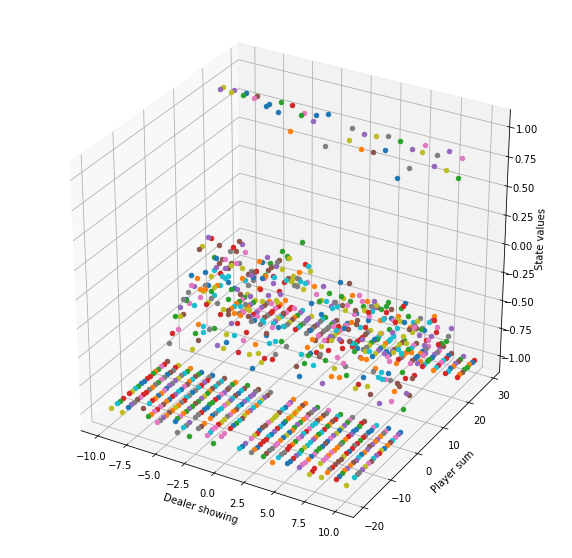

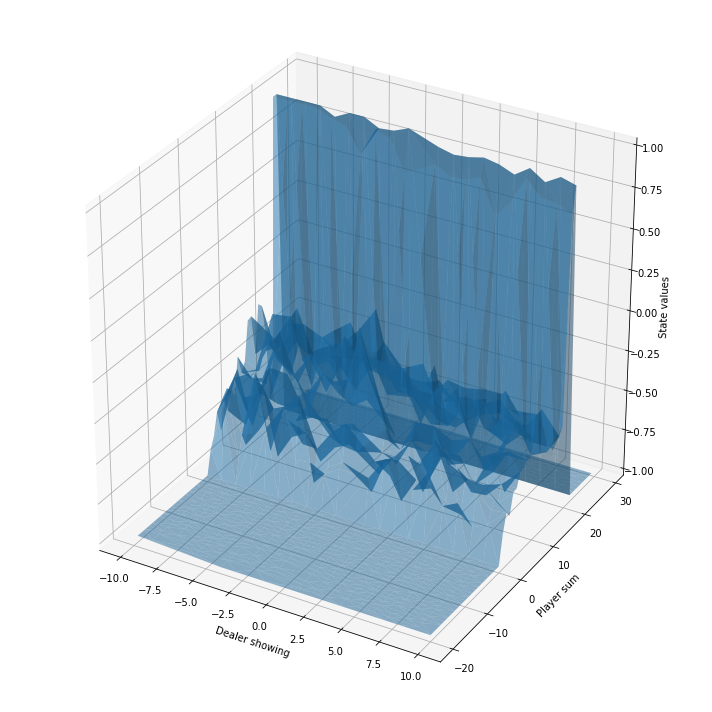

In [27]:
draw_scatter(mc_V_1)
draw_trisurf(mc_V_1)

Now the second policy $\pi_2$:

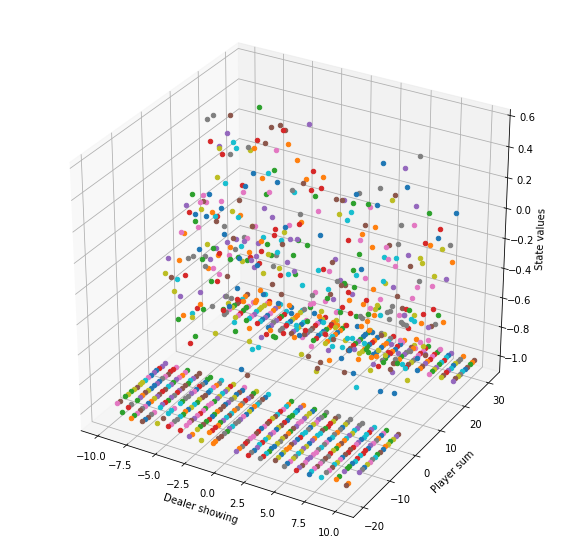

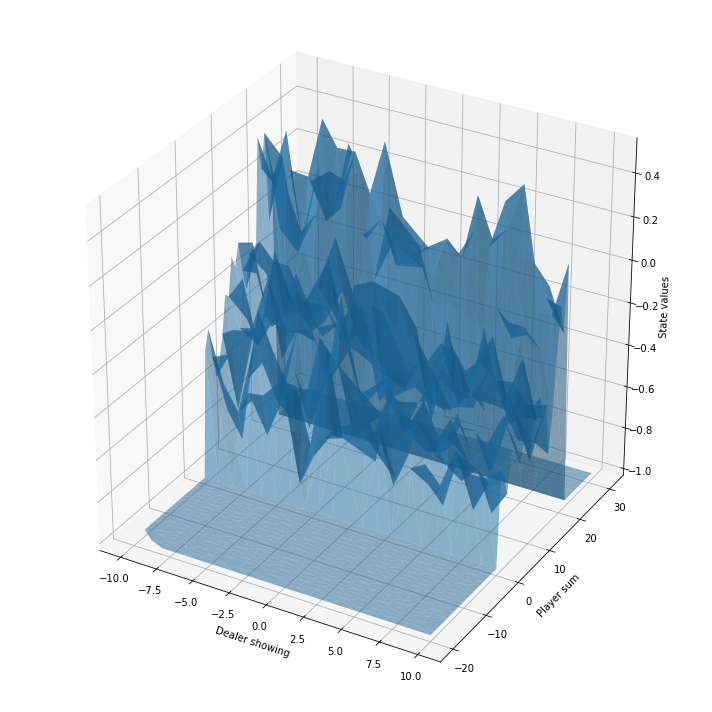

In [28]:
draw_scatter(mc_V_2)
draw_trisurf(mc_V_2)

Let's see how different *first* MC differs from the *every* variant.

Every Monte-Carlo for $\pi_1$:

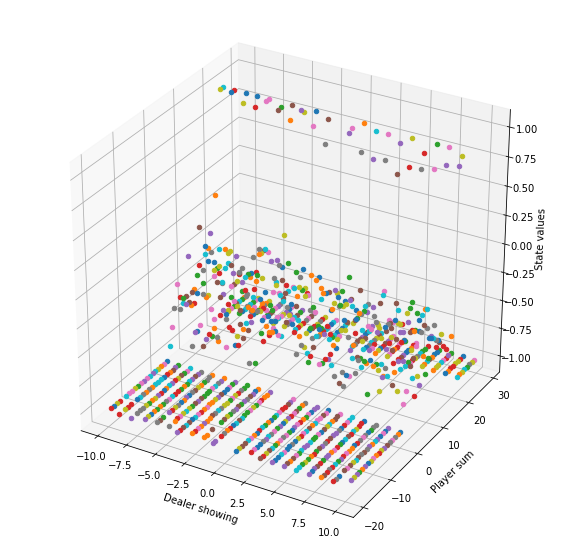

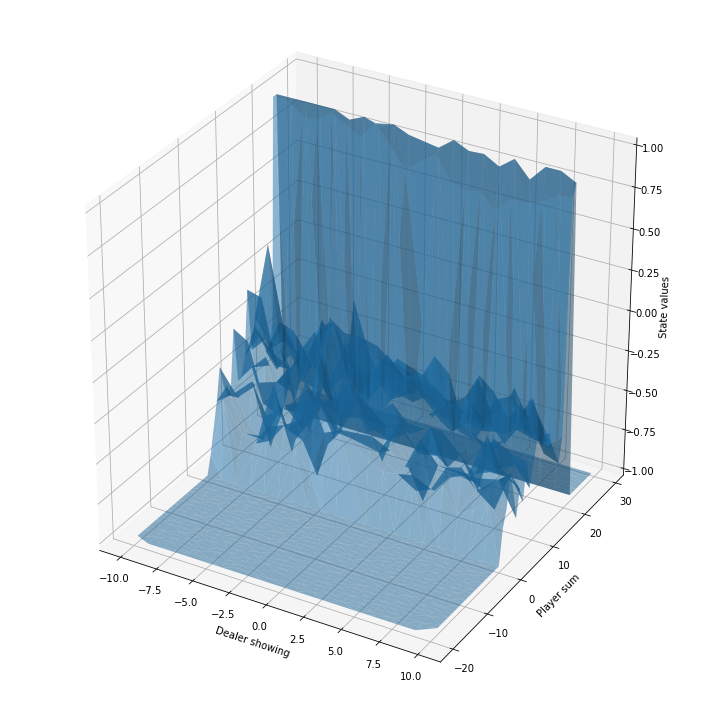

In [29]:
draw_scatter(mc_e_V_1)
draw_trisurf(mc_e_V_1)

Every MC for $\pi_2$:

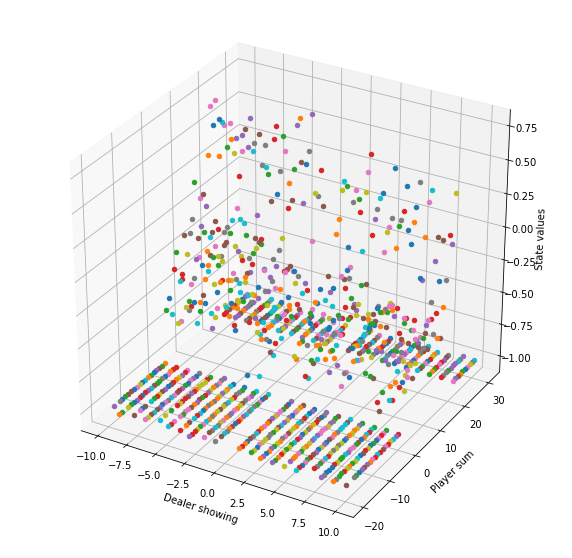

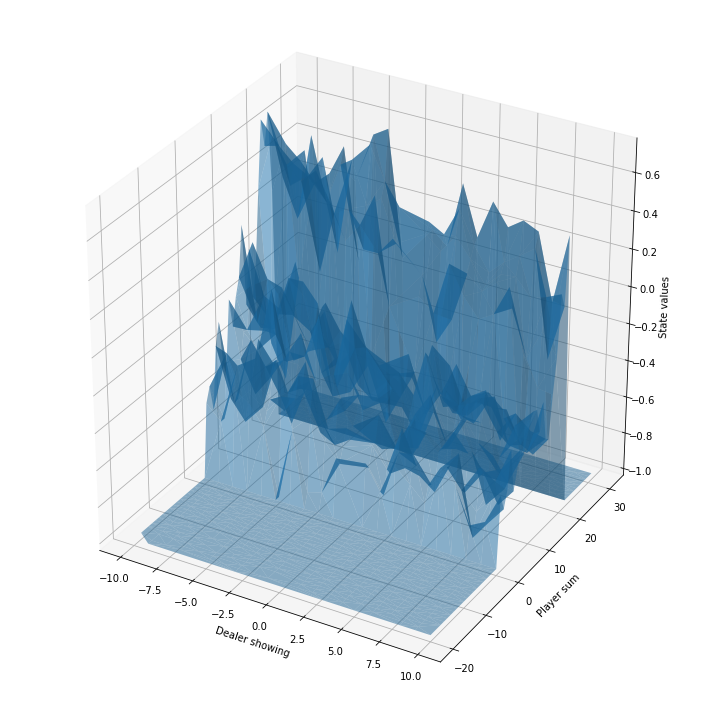

In [30]:
draw_scatter(mc_e_V_2)
draw_trisurf(mc_e_V_2)

It seems like there isn't much change. At least for the parameters we used.

#### Temporal-Difference(0)

In [31]:
# TD(0) Prediction
#   pi    - policy to be evaluated
#   n     - number of episodes to run
#   gamma - discount rate
def td_0_pred(pi, n=1000, gamma=1):
    V = defaultdict(float)
    N = defaultdict(int)
    for i in range(0, n):
        s = State(sample_card(), sample_card())
        while not s.t:
            a = sample_action(s, pi)
            r, n_s = STEP(s, a)
            h = hash(s)
            n_h = hash(n_s)
            N[h] += 1
            V[h] += (r+gamma*V[n_h]-V[h])/N[h]
            s = n_s
    return V

td_V_1 = td_0_pred(policy_1)
td_V_2 = td_0_pred(policy_2)

Let's plot TD(0)'s predictions.

First policy $\pi_1$:

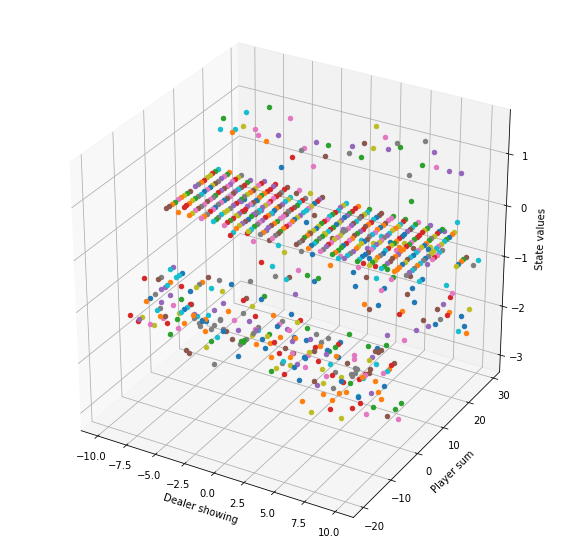

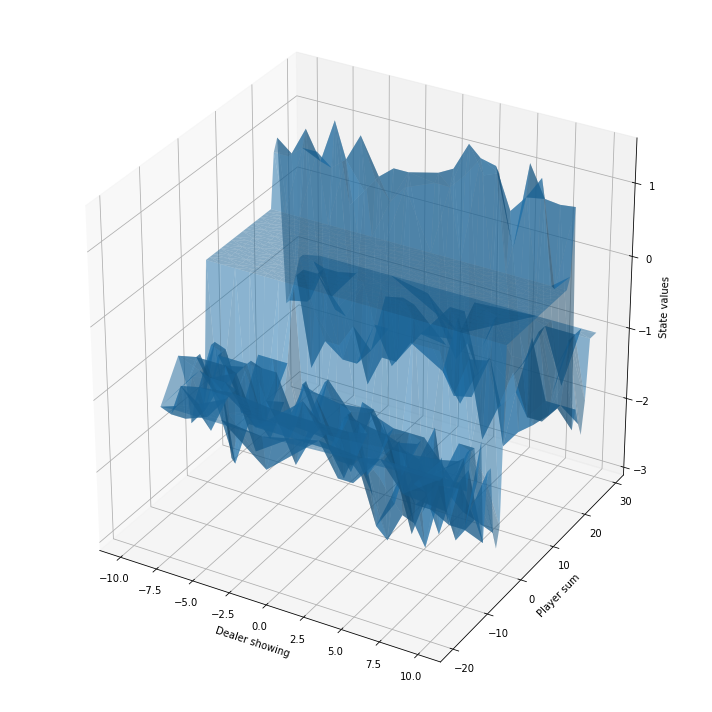

In [32]:
draw_scatter(td_V_1)
draw_trisurf(td_V_1)

Second policy $\pi_2$:

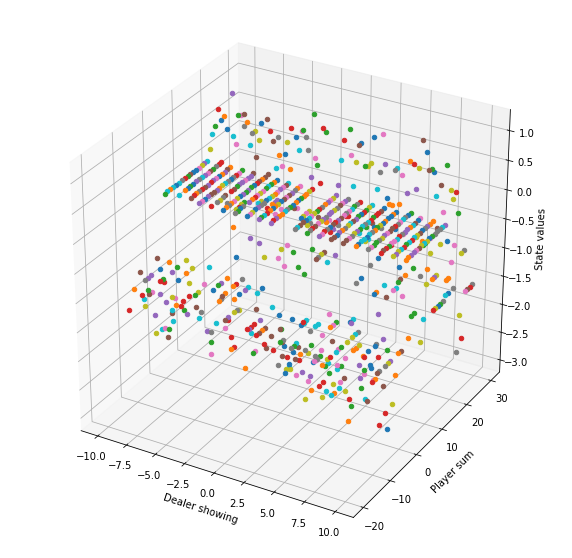

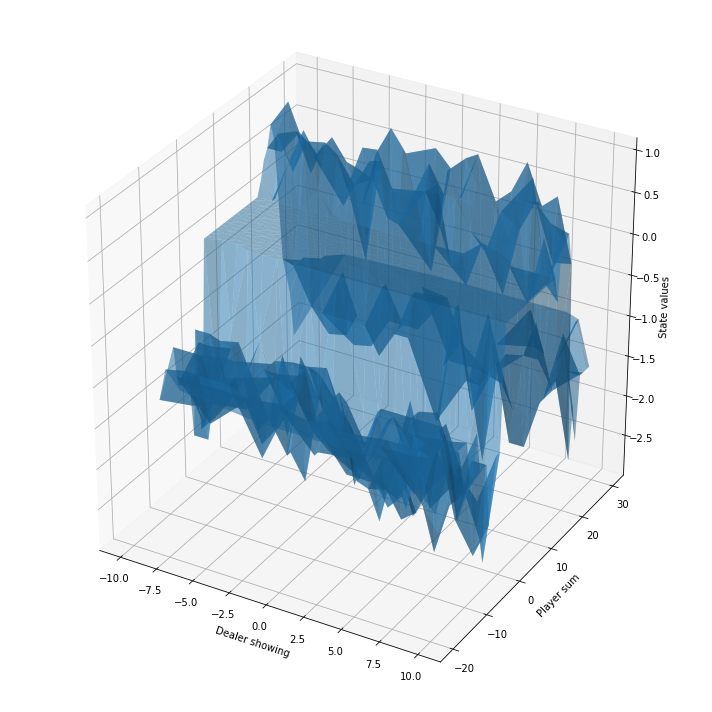

In [33]:
draw_scatter(td_V_2)
draw_trisurf(td_V_2)

#### Temporal-Difference($\lambda$)

In [76]:
# TD(lambda) Prediction
#   pi     - policy to be evaluated
#   lambda -
#   n      - number of episodes to run
def td_lambda_pred(pi, l, n=1000):
    V = defaultdict(float)
    N = defaultdict(int)
    nl = 1-l
    pl = 1
    for i in range(0, n):
        E = gen_episode(pi)
        G = 0
        G_l = 0
        for t, sar in reversed(list(enumerate(E))):
            G += sar.r
            G_l += pl*G
            pl *= l
            h = hash(sar.s)
            #if h not in V:
            #    V[h] = np.random.random()
            #    N[h] = 1
            N[h] += 1
            #print('before', V[h])
            V[h] += (nl*G_l-V[h])/N[h]
            #print('after', V[h])
            #print(G_l, nl*G_l, nl*G_l-V[h], V[h], N[h])
    return V

td_l_V_1 = td_lambda_pred(policy_1, 0.1)
td_l_V_2 = td_lambda_pred(policy_2, 0.1)

Let's plot TD($\lambda$)'s predictions.

First policy $\pi_1$:

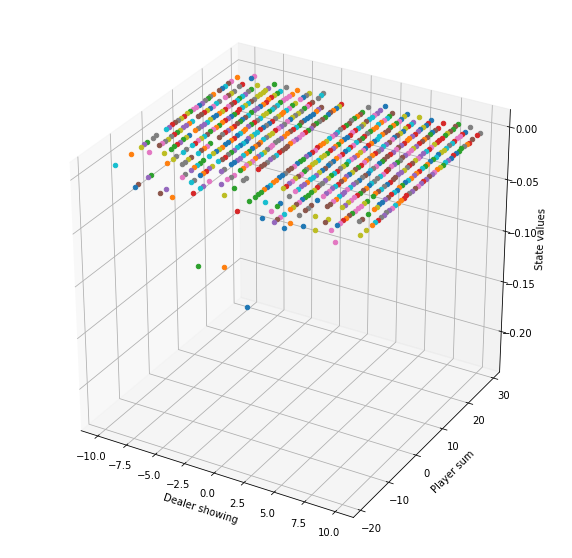

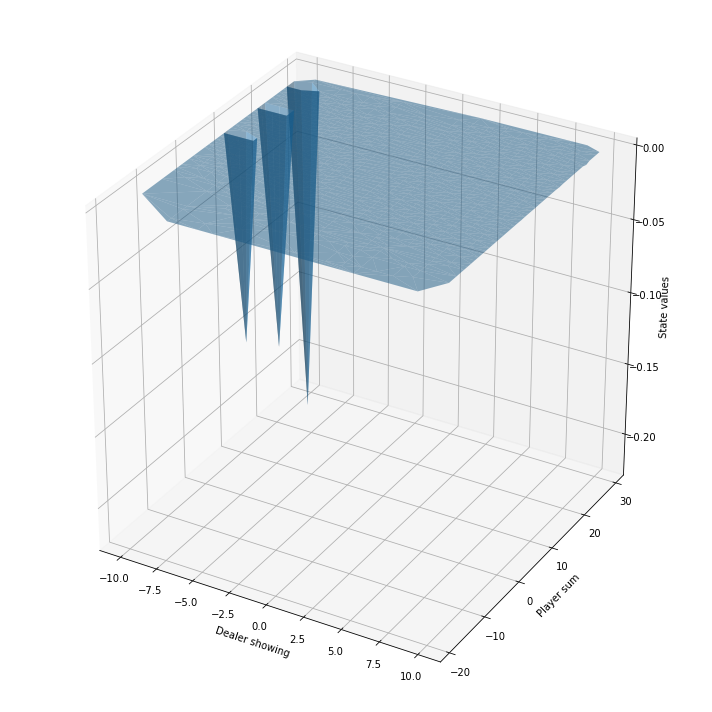

In [77]:
draw_scatter(td_l_V_1)
draw_trisurf(td_l_V_1)

Second policy $\pi_2$:

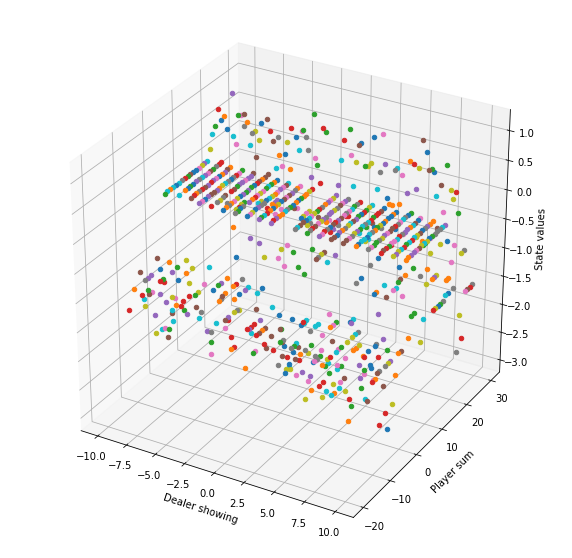

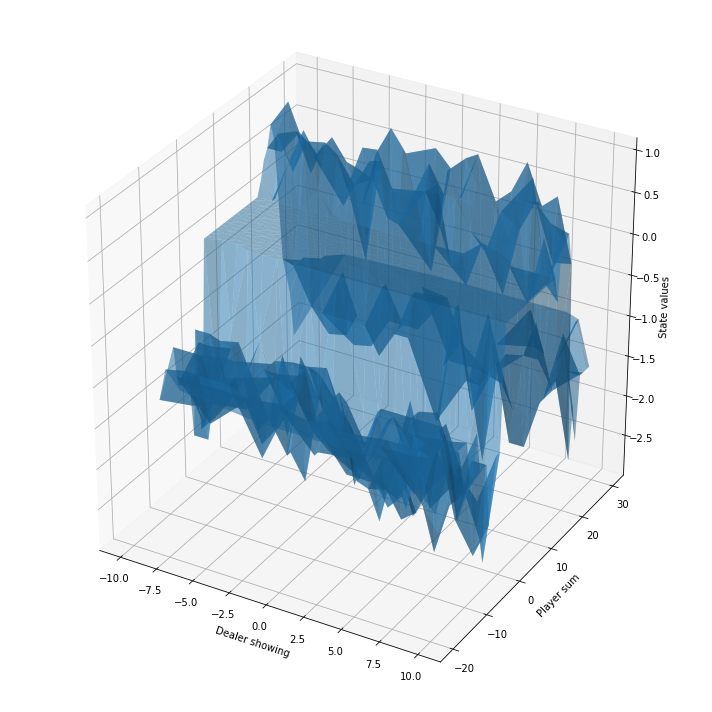

In [78]:
draw_scatter(td_V_2)
draw_trisurf(td_V_2)